In [3]:
pip install numpy pandas pymc matplotlib arviz


<ipython-input-5-ce25253307c2>:69: RuntimeWarning: overflow encountered in scalar multiply
  term1 = gamma((nu+1)/2) / (np.sqrt(nu*np.pi)*gamma(nu/2)*scale)
<ipython-input-5-ce25253307c2>:69: RuntimeWarning: invalid value encountered in scalar divide
  term1 = gamma((nu+1)/2) / (np.sqrt(nu*np.pi)*gamma(nu/2)*scale)


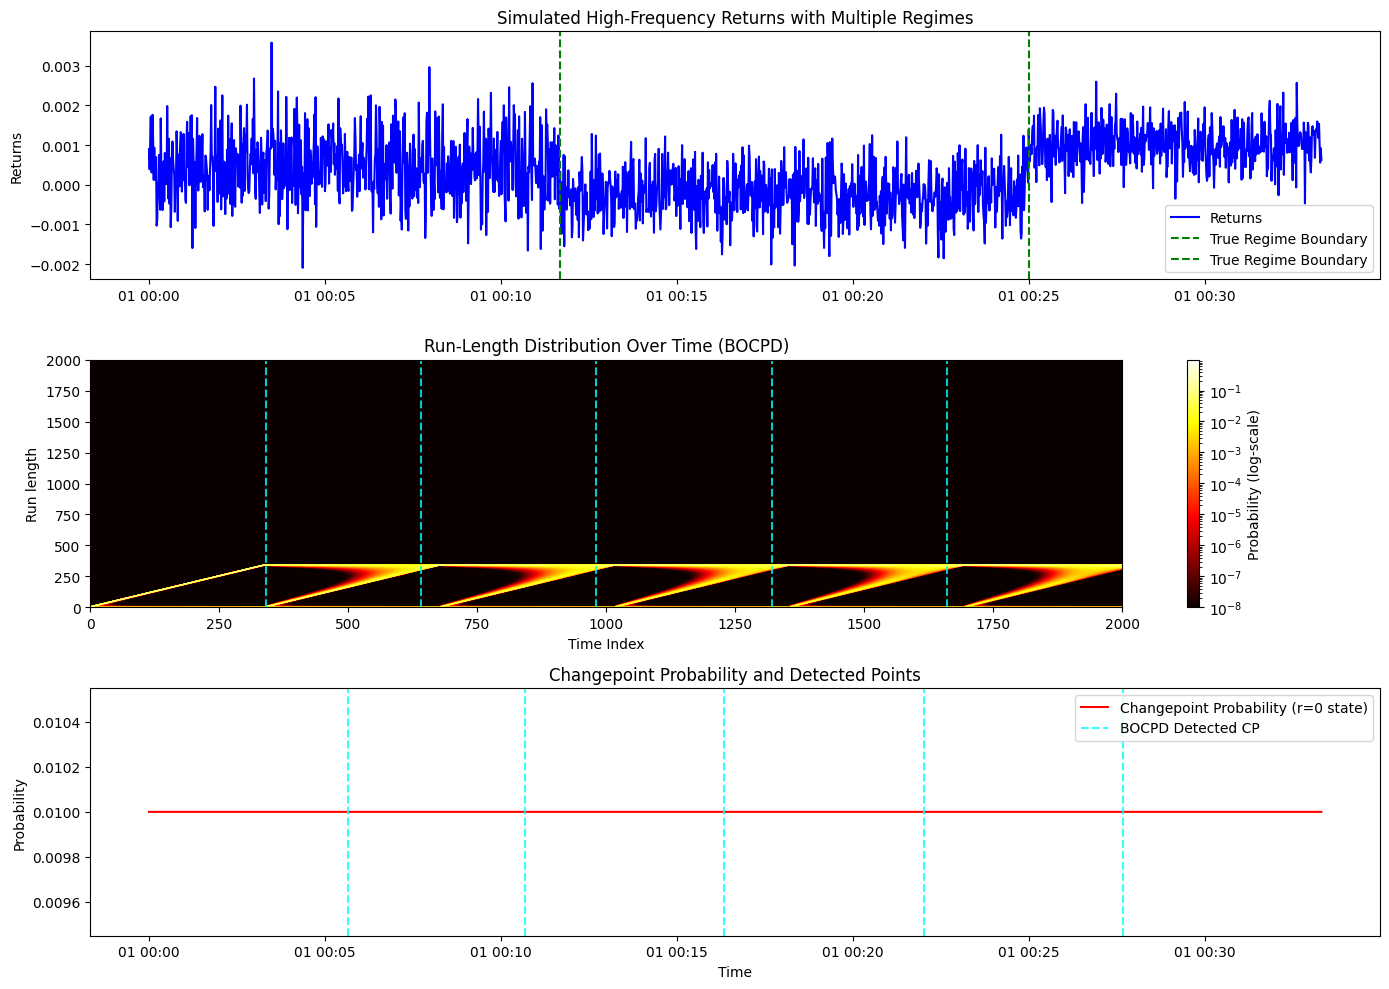

Detected changepoints via BOCPD at indices: [340, 641, 981, 1321, 1661]
True regime boundaries at indices: [ 700 1500]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.special import gamma

########################################
# Data Simulation
########################################

def simulate_crypto_returns(num_points=2000,
                            regime_params=[(0.0005, 0.0008), (-0.0003, 0.0006), (0.0010, 0.0005)],
                            regime_lengths=[700, 800, 500],
                            seed=42):
    """
    Simulate a time series of returns under multiple regimes.
    """
    np.random.seed(seed)
    timestamps = pd.date_range('2024-01-01', periods=num_points, freq='s')
    if sum(regime_lengths) != num_points:
        raise ValueError("Sum of regime_lengths must match num_points.")

    data = []
    current_index = 0
    regime_index = 0
    for (mean, std), length in zip(regime_params, regime_lengths):
        regime_data = np.random.normal(loc=mean, scale=std, size=length)
        for val in regime_data:
            data.append((timestamps[current_index], val, regime_index))
            current_index += 1
        regime_index += 1

    df = pd.DataFrame(data, columns=['timestamp', 'returns', 'true_regime'])

    if df['returns'].isnull().any():
        raise ValueError("Data contains NaNs.")

    return df

########################################
# Bayesian Online Changepoint Detection (BOCPD)
# Normal-Inverse-Gamma Conjugate Model
########################################

def student_t_pdf(x, mu, alpha, beta, kappa):
    # Degrees of freedom:
    nu = 2.0 * alpha
    if nu <= 0:
        # If nu is non-positive due to some numerical issue, return small probability
        return 1e-12

    # Scale:
    scale_sq = (beta * (kappa + 1)) / (alpha * kappa)
    if scale_sq <= 0 or np.isnan(scale_sq) or np.isinf(scale_sq):
        return 1e-12
    scale = np.sqrt(scale_sq)

    # To avoid overflow, handle large gamma arguments carefully:
    # If nu is huge, gamma((nu+1)/2) and gamma(nu/2) might overflow.
    # A safeguard: if nu is extremely large, approximate a normal distribution.
    if nu > 1000:
        # Approximate as Normal(mu, scale^2) because t-distribution with large nu ~ Normal
        var = scale_sq
        return (1.0 / (np.sqrt(2*np.pi*var))) * np.exp(-0.5*((x - mu)**2)/var)

    # Student-t PDF calculation
    # gamma((nu+1)/2) / ( sqrt(nu*pi)*gamma(nu/2)*scale ) * [1 + ((x-mu)^2/(nu*scale^2))]^(-(nu+1)/2)
    try:
        term1 = gamma((nu+1)/2) / (np.sqrt(nu*np.pi)*gamma(nu/2)*scale)
    except (OverflowError, FloatingPointError):
        # If still overflow, return small probability
        return 1e-12

    z = ((x - mu)**2)/(nu*(scale**2))
    term2 = (1 + z)**(-(nu+1)/2)

    # Check for nan or inf
    if np.isnan(term1) or np.isinf(term1) or np.isnan(term2) or np.isinf(term2):
        return 1e-12

    val = term1 * term2
    if np.isnan(val) or np.isinf(val):
        return 1e-12
    return max(val, 1e-12)


def update_posterior_params(x, mu, kappa, alpha, beta):
    kappa_new = kappa + 1.0
    mu_new = (kappa*mu + x)/kappa_new
    alpha_new = alpha + 0.5
    # To prevent beta from blowing up too large, we can clip the increment
    increment = 0.5*( (kappa*(x - mu)**2)/kappa_new )
    increment = min(increment, 1e5)  # arbitrary large cap
    beta_new = beta + increment
    # Clip parameters to prevent overflow
    if beta_new > 1e10:
        beta_new = 1e10
    if alpha_new > 1e7:
        alpha_new = 1e7
    if kappa_new > 1e7:
        kappa_new = 1e7
    return mu_new, kappa_new, alpha_new, beta_new


def bocpd(data, hazard=0.005,
          mu0=0.0, kappa0=0.01, alpha0=1.0, beta0=1.0):
    """
    Bayesian Online Changepoint Detection.
    """
    T = len(data)
    R = np.zeros((T+1, T+1))
    R[0,0] = 1.0

    post_params = [[{'mu': mu0, 'kappa': kappa0, 'alpha': alpha0, 'beta': beta0}]]

    for t in range(1, T+1):
        x = data[t-1]
        pred_probs = np.zeros(t)

        for r in range(t):
            params = post_params[t-1][r]
            mu = params['mu']
            kappa = params['kappa']
            alpha = params['alpha']
            beta = params['beta']
            pred = student_t_pdf(x, mu, alpha, beta, kappa)
            pred_probs[r] = pred

        # Update run-length distribution
        # Growth probabilities
        R[t,1:t+1] = R[t-1,0:t]*pred_probs*(1 - hazard)
        # New regime probability
        R[t,0] = np.sum(R[t-1,0:t]*pred_probs*hazard)

        # Normalize
        total_prob = np.sum(R[t,:t+1])
        if total_prob == 0 or np.isnan(total_prob):
            # If total_prob is zero or nan, fallback
            R[t,:t+1] = 1e-12
            total_prob = np.sum(R[t,:t+1])
        R[t,:t+1] /= total_prob

        # Update posterior parameters
        current_params = []
        # r=0 new regime
        mu_new, kappa_new, alpha_new, beta_new = update_posterior_params(x, mu0, kappa0, alpha0, beta0)
        current_params.append({'mu': mu_new, 'kappa': kappa_new, 'alpha': alpha_new, 'beta': beta_new})

        # r>0
        for r in range(1,t+1):
            params = post_params[t-1][r-1]
            mu = params['mu']
            kappa = params['kappa']
            alpha = params['alpha']
            beta = params['beta']
            mu_up, kappa_up, alpha_up, beta_up = update_posterior_params(x, mu, kappa, alpha, beta)
            current_params.append({'mu': mu_up, 'kappa': kappa_up, 'alpha': alpha_up, 'beta': beta_up})

        post_params.append(current_params)

    return R, post_params

def get_map_changepoints(R):
    T = R.shape[0]-1
    map_rl = np.zeros(T, dtype=int)
    for t in range(T):
        map_rl[t] = np.argmax(R[t+1,:t+2])

    changepoints = []
    idx = T-1
    while idx >= 0:
        cp = idx - map_rl[idx] + 1
        if cp > 0 and cp < T:
            changepoints.append(cp)
        idx = cp - 2
    changepoints = sorted(set(changepoints))
    # Clip changepoints to data range
    changepoints = [cp for cp in changepoints if 0 <= cp < T]
    return changepoints

if __name__ == "__main__":
    df = simulate_crypto_returns(num_points=2000,
                                 regime_params=[(0.0005, 0.0008), (-0.0003, 0.0006), (0.0010, 0.0005)],
                                 regime_lengths=[700, 800, 500],
                                 seed=42)
    data = df['returns'].values

    # Adjusting priors/hazard for better stability
    R, post_params = bocpd(data, hazard=0.01, mu0=0.0, kappa0=0.1, alpha0=1.0, beta0=1.0)
    changepoints = get_map_changepoints(R)

    # Plot results
    fig = plt.figure(figsize=(14,10))
    ax1 = plt.subplot2grid((3,1), (0,0))
    ax2 = plt.subplot2grid((3,1), (1,0))
    ax3 = plt.subplot2grid((3,1), (2,0))

    ax1.plot(df['timestamp'], df['returns'], color='blue', label='Returns')
    ax1.set_title('Simulated High-Frequency Returns with Multiple Regimes')
    ax1.set_ylabel('Returns')
    ax1.legend()

    # True regime boundaries
    boundaries = np.cumsum([0]+[700, 800, 500])
    for b in boundaries[1:-1]:
        if b < len(df):
            ax1.axvline(df['timestamp'].iloc[b], color='green', linestyle='--', label='True Regime Boundary')
    ax1.legend()

    R_plot = R[1:,:-1]
    eps = 1e-8
    im = ax2.imshow(R_plot.T+eps, origin='lower', aspect='auto', cmap='hot', norm=LogNorm(), extent=[0, len(data), 0, len(data)])
    ax2.set_title('Run-Length Distribution Over Time (BOCPD)')
    ax2.set_ylabel('Run length')
    ax2.set_xlabel('Time Index')
    cbar = fig.colorbar(im, ax=ax2, label='Probability (log-scale)')

    # Mark detected changepoints
    for cp in changepoints:
        if cp < len(df):
            ax2.axvline(cp, color='cyan', linestyle='--', alpha=0.8)

    cp_probs = R[1:,0]
    ax3.plot(df['timestamp'], cp_probs, color='red', label='Changepoint Probability (r=0 state)')
    for cp in changepoints:
        if cp < len(df):
            ax3.axvline(df['timestamp'].iloc[cp], color='cyan', linestyle='--', alpha=0.8, label='BOCPD Detected CP')
    ax3.set_title('Changepoint Probability and Detected Points')
    ax3.set_ylabel('Probability')
    ax3.set_xlabel('Time')
    handles, labels = ax3.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax3.legend(by_label.values(), by_label.keys(), loc='best')

    plt.tight_layout()
    plt.show()

    if df.isnull().any().any():
        raise ValueError("Output DataFrame contains NaN values.")

    print("Detected changepoints via BOCPD at indices:", changepoints)
    print("True regime boundaries at indices:", boundaries[1:-1])
